In [ ]:
#!pip install neuralforecast

# **LIBRARY PREPARATION**

In [ ]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, FEDformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset

from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from scipy.signal import savgol_filter

# **DIG DATA PREPARATION**

In [ ]:
# Read Data
df = pd.read_csv('DIG Historical Data 1_6 Fed.csv')

In [ ]:
# Add ID constraint
df1 = df
df1['unique_id'] = 'DIG'

# Reorder columns
df1 = df1[['unique_id', 'Date', 'Price']]

# Rename
df1.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)
df1

,unique_id,ds,y
0,DIG,2018-01-02,11033.20
1,DIG,2018-01-03,11457.60
2,DIG,2018-01-04,12094.10
3,DIG,2018-01-05,12094.10
4,DIG,2018-01-06,11669.75
...,...,...,...
2338,DIG,2024-05-28,27850.00
2339,DIG,2024-05-29,27950.00
2340,DIG,2024-05-30,27600.00
2341,DIG,2024-05-31,27750.00


In [ ]:
# Change Data Type
df1['ds'] = pd.to_datetime(df1['ds'])
df1['y'] = df1['y'].astype(float)

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  2343 non-null   object        
 1   ds         2343 non-null   datetime64[ns]
 2   y          2343 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 55.0+ KB


# **TRAIN-TEST SPLIT**

In [ ]:
# Sizing
size = int(len(df1))

# 8 : 2 Ratio
train_data = df1[:int(0.8 *size)]
test_data = df1[int(0.8 * size):]
train_len = len(train_data)
test_len = len(test_data)
print("Training lenght:" , train_len)
print("Test lenght:" , test_len)

Training lenght: 1874
Test lenght: 469


In [ ]:
# Train_data MAX Value
train_data.max()

unique_id                    DIG
ds           2023-02-18 00:00:00
y                        98196.7
dtype: object

# **TRAINING PROCESSS**

In [ ]:
# Model Configuration
model = FEDformer(
    h=test_len + 90,
    input_size = 120,  # 120 Days of input size
    modes=64,  # Reduced modes for less complexity
    hidden_size=128,  # Increased hidden size
    n_head=8,  # Must be set to 8
    loss=MAE(),
    scaler_type='standard',  # Change the scaler type
    learning_rate=1e-3,  # Fine-tune the learning rate
    max_steps=100,  # Increase the number of training steps
    batch_size=32,  # Adjust batch size
    windows_batch_size=256,  # Adjust window batch size
)

nf = NeuralForecast(
    models=[model],
    freq='D',
)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
# Training
nf.fit(df=train_data, static_df=None, verbose=True)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 271 K  | train
7 | decoder       | Decoder       | 403 K  | train
--------------------------------------------------------
675 K     Trainable params
0         Non-trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


# **PREDICTION**


In [ ]:
forecasts = nf.predict()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
# Reset Index
train = train_data['y']
test = test_data['y']

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

predict = forecasts['FEDformer']
predict.reset_index(drop=True, inplace=True)

In [ ]:
predict_test = predict[0:test_len]
predict_future = predict[test_len:]

In [ ]:
# Order predict_future
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]

In [ ]:
# Print Predicted Data
print("\nPredicted Data for the next 30 days:")
print(predict_future_30)

print("\nPredicted Data for the next 60 days:")
print(predict_future_60)

print("\nPredicted Data for the next 90 days:")
print(predict_future_90)


Predicted Data for the next 30 days:
469    24072.884766
470    24253.816406
471    23806.308594
472    24209.242188
473    23341.126953
474    23159.207031
475    24121.308594
476    25593.050781
477    25307.882812
478    22829.636719
479    23151.310547
480    22743.255859
481    21402.998047
482    21983.652344
483    21268.423828
484    20218.156250
485    20883.226562
486    20404.027344
487    20610.105469
488    19138.974609
489    20424.447266
490    20278.015625
491    19660.621094
492    18676.878906
493    19562.033203
494    18128.822266
495    18147.775391
496    16172.521484
497    17062.781250
498    18606.771484
Name: FEDformer, dtype: float32

Predicted Data for the next 60 days:
499    19447.302734
500    19556.830078
501    19038.023438
502    19463.058594
503    19026.208984
504    18993.662109
505    20640.492188
506    20623.525391
507    22025.685547
508    21984.769531
509    20600.128906
510    22225.468750
511    23353.605469
512    21396.671875
513    20112

# **EVALUATION**

In [ ]:
mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
mse = mean_squared_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 6988.793134633752
Mean Absolute Percentage Error (MAPE): 0.27910001870291984
Mean Square Error (MSE): 60870003.694021486
Root Mean Square Error (RMSE): 7801.923076653697


# **VISUALIZATION**

In [ ]:
# prompt: adding first_value to the last of test
first_value = predict_test.iloc[0]
train_draw = pd.concat([train, pd.Series([first_value])], ignore_index=True)

**Overall Visualization**

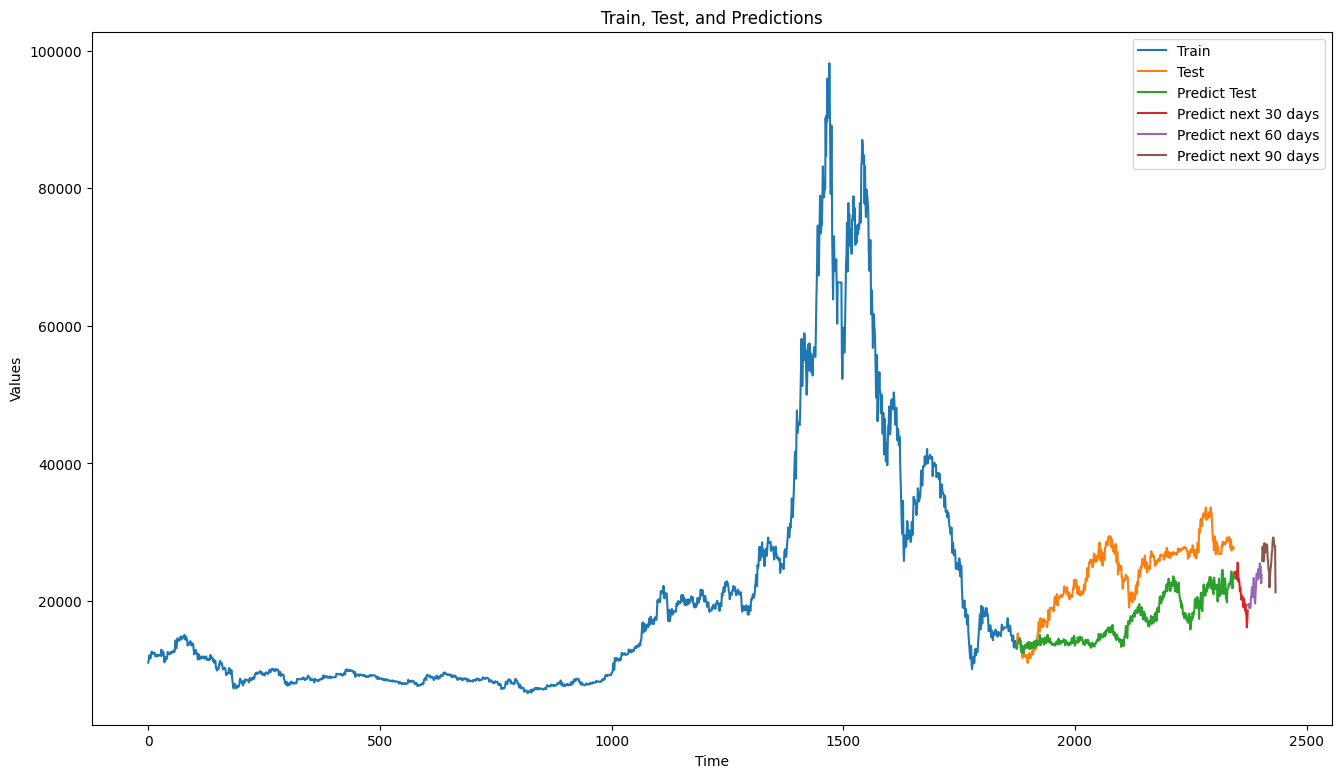

In [ ]:
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)

predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))

predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Train, Test, and Predictions')
plt.show()

# **---------------------------------------**

# **POLYNOMINAL SMOOTHING**

In [ ]:
predict_smoothed = savgol_filter(predict, window_length=31, polyorder=3)

# **RE - PREDICTION**


In [ ]:
predict_test = predict_smoothed[0:test_len]
predict_future = predict_smoothed[test_len:]

In [ ]:
# Order predict_future
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]

In [ ]:
# Print Predicted Data
print("\nPredicted Data for the next 30 days:")
print(predict_future_30)

print("\nPredicted Data for the next 60 days:")
print(predict_future_60)

print("\nPredicted Data for the next 90 days:")
print(predict_future_90)


Predicted Data for the next 30 days:
[24021.209 24044.943 24040.525 23971.57  23944.436 23788.96  23616.277
 23427.225 23260.172 23071.582 22936.531 22702.836 22439.404 22165.21
 21760.656 21324.924 20922.447 20573.895 20204.84  19902.955 19584.244
 19208.967 18935.84  18753.861 18671.264 18617.049 18568.188 18535.15
 18602.38  18799.566]

Predicted Data for the next 60 days:
[19010.85  19113.725 19230.57  19311.96  19474.16  19652.266 19900.72
 20159.133 20492.322 20799.379 21076.428 21348.305 21618.006 21878.799
 22067.188 22213.639 22327.496 22506.297 22751.652 22945.324 23072.777
 23267.967 23492.271 23724.73  24079.393 24398.79  24669.514 25089.701
 25578.691 25984.29 ]

Predicted Data for the next 90 days:
[26261.146 26510.957 26650.824 26725.379 26807.668 26821.545 26722.088
 26631.885 26521.008 26358.129 26208.021 26216.959 26198.824 26192.863
 26326.87  26259.93  26200.09  26150.23  26113.234 26091.982 26089.36
 26108.244 26151.521 26222.074 26322.781 26456.527 26626.193 2683

# **RE - EVALUATION**

In [ ]:
mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
mse = mean_squared_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 6986.1019865793805
Mean Absolute Percentage Error (MAPE): 0.27896308229505257
Mean Square Error (MSE): 60535230.79180674
Root Mean Square Error (RMSE): 7780.438984517952


# **RE - VISUALIZATION**

In [ ]:
# Assuming predict_test is a NumPy array
first_value = pd.Series(predict_test.reshape(-1))  # Convert to pandas Series

# Concatenate train and first_value as Series in a new DataFrame
train_draw = pd.concat([train, first_value], ignore_index=True)

**Overall Visualization**

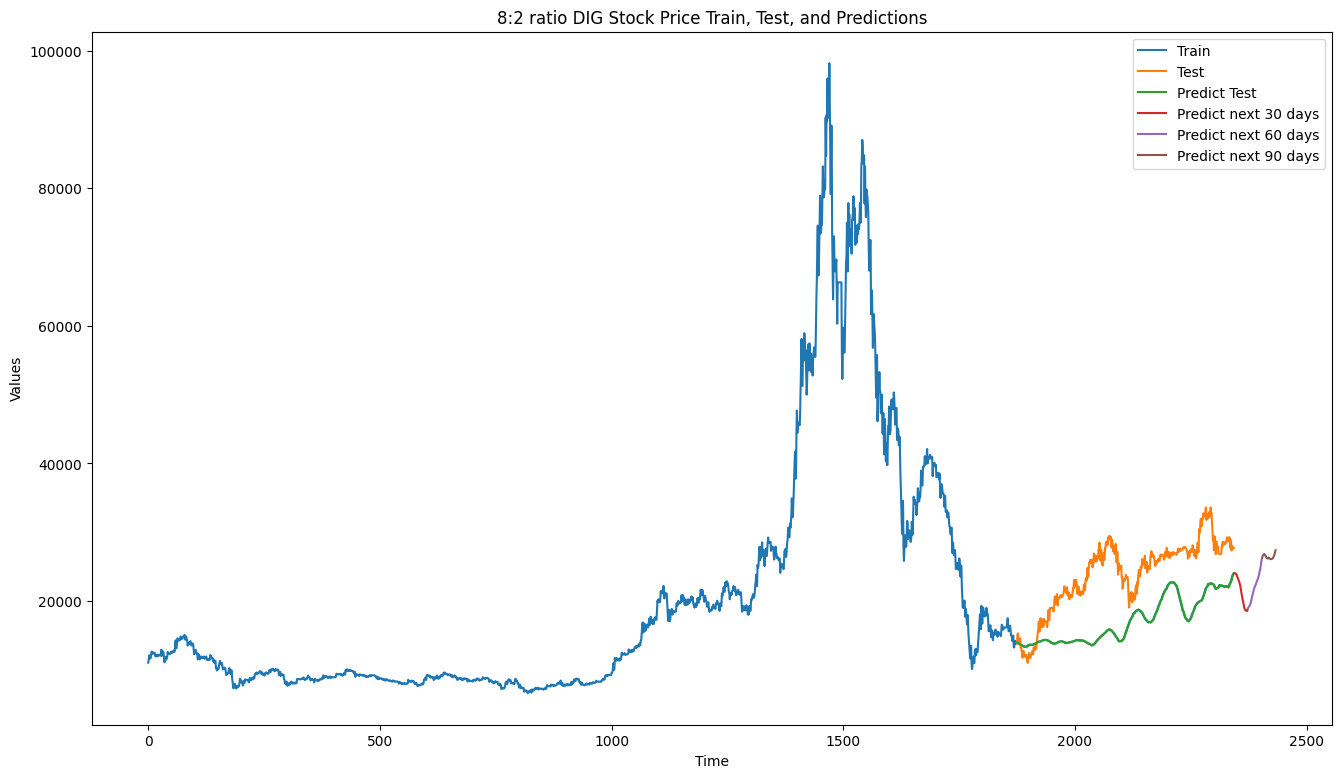

In [ ]:
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)

predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))

predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('8:2 ratio DIG Stock Price Train, Test, and Predictions')
plt.show()